In [39]:
!pip install memory_profiler

In [40]:
import cv2
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import random
import time
import memory_profiler
import xml.etree.ElementTree as ET
import torchvision.transforms as T
from PIL import Image
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from torch.utils.data import DataLoader, Dataset
from matplotlib import pyplot as plt
from matplotlib import patches
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [41]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device=torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [42]:
from torchvision.datasets import VOCDetection
#downLoad Pascal VOC dataset
VOCDetection(root='VOC_data', year='2012', image_set='trainval', download=True)

Using downloaded and verified file: VOC_data/VOCtrainval_11-May-2012.tar
Extracting VOC_data/VOCtrainval_11-May-2012.tar to VOC_data


Dataset VOCDetection
    Number of datapoints: 11540
    Root location: VOC_data

In [43]:
VOC_CLASSES_original = {
    "aeroplane": 1, "bicycle": 2, "bird": 3, "boat": 4, "bottle": 5,
    "bus": 6, "car": 7, "cat": 8, "chair": 9, "cow": 10,
    "diningtable": 11, "dog": 12, "horse": 13, "motorbike": 14, "person": 15,
    "pottedplant": 16, "sheep": 17, "sofa": 18, "train": 19, "tvmonitor": 20
}

In [44]:
# Define VOC_CLASSES for segmentation
VOC_CLASSES = {
    "bicycle": 2, "bus": 6, "car": 7, "motorbike": 14, "person": 15
}
# Re-index values
VOC_CLASSES_ReIndex = {name: idx+1 for idx, (name, _) in enumerate(VOC_CLASSES.items())}
print(VOC_CLASSES_ReIndex)

{'bicycle': 1, 'bus': 2, 'car': 3, 'motorbike': 4, 'person': 5}


In [45]:
class Config:
    root_dir = '/content/VOC_data/VOCdevkit/VOC2012'
    #root_dir = 'VOC2012'
    num_epochs = 30
    batch_size = 8
    learning_rate = 0.002 #0.005
    momentum = 0.9
    weight_decay = 0.0005
    iou_threshold = 0.5
    patience = 10
    classes = VOC_CLASSES_ReIndex
    subset_size_class = 11000
    val_split = 0.2

In [46]:
# make subset class balanced
def getSubsetClasses(root, classes, image_set,  subset_size_class):

    image_dir = os.path.join(root, "JPEGImages")
    annotation_dir = os.path.join(root, "Annotations")
    image_set_file = os.path.join(root, "ImageSets", "Main", f"{image_set}.txt")

    tmp_ImgSet = []
    for imgSet in os.listdir(os.path.join(root, "ImageSets", "Main")):
        if imgSet.endswith(f"_{image_set}.txt"):
            subset_class = imgSet.split("_")[0]
            if str(subset_class) in classes.keys():
                subset_class_path = os.path.join(root, "ImageSets", "Main", f"{subset_class}_{image_set}.txt")
                with open(subset_class_path) as f:
                    image_ids = [line.strip().split(" ")[0] for line in f.readlines()]
                    #print(len(image_ids))
                    image_ids = random.sample(image_ids, subset_size_class) # make subset
                tmp_ImgSet.extend(image_ids)
    tmp_ImgSet = set(tmp_ImgSet)

    tmp = []
    for image_id in tmp_ImgSet:
        img_path = os.path.join(image_dir, f"{image_id}.jpg")
        annotation_path = os.path.join(annotation_dir, f"{image_id}.xml")

        tree = ET.parse(annotation_path)
        root_tree = tree.getroot()

        for obj in root_tree.iter('object'):
            class_name = obj.find('name').text
            if class_name in classes:
                tmp.append(image_id)

    subset=list(set(tmp)) #get unique file

    if image_set == 'trainval':

        subset_train, subset_val = train_test_split(subset, test_size=Config.val_split, random_state=42)
        print(f'{image_set} {len(subset)} images')
        print(f'train {len(subset_train)} images')
        print(f'val {len(subset_val)} images')

        new_set_file = os.path.join(root, "ImageSets", "Main", "train_subsetBalanced.txt")
        with open(new_set_file, "w") as file:
            for value in subset_train:
                file.write(f"{value}\n")
        new_set_file = os.path.join(root, "ImageSets", "Main", "val_subsetBalanced.txt")
        with open(new_set_file, "w") as file:
            for value in subset_val:
                file.write(f"{value}\n")
    else:
        print(f'{image_set} {len(subset)} images')
        new_set_file = os.path.join(root, "ImageSets", "Main", f"{image_set}_subsetBalanced.txt")
        with open(new_set_file, "w") as file:
            for value in subset:
                file.write(f"{value}\n")


In [47]:
# get subset classes
getSubsetClasses(root=Config.root_dir, classes=VOC_CLASSES, image_set='trainval', subset_size_class=Config.subset_size_class)
#getSubsetClasses(root=Config.root_dir, classes=VOC_CLASSES, image_set='train', subset_size_class=Config.subset_size_class)
#getSubsetClasses(root=Config.root_dir, classes=VOC_CLASSES, image_set='val', subset_size_class=int(Config.subset_size_class * 0.1))


trainval 5607 images
train 4485 images
val 1122 images


In [48]:
def get_model(num_classes):
    # Load pre-trained Faster R-CNN model with ResNet50 backbone
    model = fasterrcnn_resnet50_fpn(
        weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT,
        progress=True,
        weights_backbone=ResNet50_Weights.DEFAULT,
        trainable_backbone_layers=5
    )

    # Custom anchor generation
    anchor_sizes = ((16,), (32,), (64,), (128,), (256,))  # Custom sizes for each feature map level # check image size
    aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes) # Same aspect ratios for all levels
    anchor_generator = AnchorGenerator(
        sizes=anchor_sizes,
        aspect_ratios=aspect_ratios
    )
    model.rpn.anchor_generator = anchor_generator

    # Custom ROI Align layer
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0', '1', '2', '3'],
        output_size=7,
        sampling_ratio=2
    )
    model.roi_heads.box_roi_pool = roi_pooler

    # Replace classifier head
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [49]:
# Load the Mask R-CNN model
model = get_model(len(Config.classes)+1)
model = model.to(device)

In [50]:
# fine tunned classes
model.roi_heads.box_predictor

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=6, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=24, bias=True)
)

In [51]:
trainable_params = [name for name, param in model.named_parameters() if param.requires_grad]
print(trainable_params)

['backbone.body.conv1.weight', 'backbone.body.layer1.0.conv1.weight', 'backbone.body.layer1.0.conv2.weight', 'backbone.body.layer1.0.conv3.weight', 'backbone.body.layer1.0.downsample.0.weight', 'backbone.body.layer1.1.conv1.weight', 'backbone.body.layer1.1.conv2.weight', 'backbone.body.layer1.1.conv3.weight', 'backbone.body.layer1.2.conv1.weight', 'backbone.body.layer1.2.conv2.weight', 'backbone.body.layer1.2.conv3.weight', 'backbone.body.layer2.0.conv1.weight', 'backbone.body.layer2.0.conv2.weight', 'backbone.body.layer2.0.conv3.weight', 'backbone.body.layer2.0.downsample.0.weight', 'backbone.body.layer2.1.conv1.weight', 'backbone.body.layer2.1.conv2.weight', 'backbone.body.layer2.1.conv3.weight', 'backbone.body.layer2.2.conv1.weight', 'backbone.body.layer2.2.conv2.weight', 'backbone.body.layer2.2.conv3.weight', 'backbone.body.layer2.3.conv1.weight', 'backbone.body.layer2.3.conv2.weight', 'backbone.body.layer2.3.conv3.weight', 'backbone.body.layer3.0.conv1.weight', 'backbone.body.laye

In [52]:
trainable_params_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(trainable_params_count)

41319661


In [53]:
params = [param for name, param in model.named_parameters() if param.requires_grad]
len(params )

83

In [54]:
# transform original
model.transform

GeneralizedRCNNTransform(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    Resize(min_size=(800,), max_size=1333, mode='bilinear')
)

In [55]:
# Adjust the model transform
model.transform = GeneralizedRCNNTransform(
    min_size=400,
    max_size=600,
    image_mean=[0.485, 0.456, 0.406],
    image_std=[0.229, 0.224, 0.225],
)

In [56]:
# transform custom in model
model.transform

GeneralizedRCNNTransform(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    Resize(min_size=(400,), max_size=600, mode='bilinear')
)

In [57]:
# Custom transform to resize and normalize both image and boxes
class ResizeNormalizeTransform:
    def __init__(self, normalize = False, min_size=400, max_size=600, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):

        self.normalize = normalize # normalize in model.transform
        self.min_size = min_size
        self.max_size = max_size
        self.mean = mean
        self.std = std

    def __call__(self, image, boxes):
        # Original image size
        original_width, original_height = image.size

        # Calculate scaling factor to maintain aspect ratio
        min_original_size = float(min(original_width, original_height))
        max_original_size = float(max(original_width, original_height))

        # Calculate scale factor
        scale = self.min_size / min_original_size

        # Check if the scaling would make the longer side too big
        if scale * max_original_size > self.max_size:
            scale = self.max_size / max_original_size

        # Calculate new size
        new_width = int(original_width * scale)
        new_height = int(original_height * scale)

        # Resize image
        image = T.Resize((new_height, new_width))(image)

        # Adjust bounding boxes
        if boxes is not None and len(boxes):
            boxes = boxes.clone()
            boxes[:, [0, 2]] *= (new_width / original_width)  # Scale x coordinates
            boxes[:, [1, 3]] *= (new_height / original_height)  # Scale y coordinates

        # Convert image to tensor and normalize
        image = T.ToTensor()(image)
        if self.normalize:
            image = T.Normalize(mean=self.mean, std=self.std)(image)

        return image, boxes

# Instance transformation
transform = ResizeNormalizeTransform()


In [58]:
class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, root, classes, image_set, transform=None):
        super().__init__()

        self.root = root
        self.classes = classes
        self.image_set = image_set
        self.transform = transform

        # Paths to images and annotations
        self.image_dir = os.path.join(root, "JPEGImages")
        self.annotation_dir = os.path.join(root, "Annotations")
        self.image_set_file = os.path.join(root, "ImageSets", "Main", f"{image_set}_subsetBalanced.txt")

        # Read image ids
        with open(self.image_set_file) as f:
            self.image_ids = f.read().strip().split()

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]

        # Load image
        img_path = os.path.join(self.image_dir, f"{image_id}.jpg")
        image = Image.open(img_path).convert("RGB")

        # Load annotation
        annot_path = os.path.join(self.annotation_dir, f"{image_id}.xml")

        boxes, labels = self.parse_voc_xml(annot_path)

        # Apply transformations to image and boxes
        if self.transform:
            image, boxes = self.transform(image, boxes)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx])
        }

        return image, target

    def parse_voc_xml(self, xml_path):
        tree = ET.parse(xml_path)
        root = tree.getroot()

        boxes = []
        labels = []

        for obj in root.findall("object"):
            label = obj.find("name").text
            if label in self.classes:
                labels.append(self.classes[label])

                bbox = obj.find("bndbox")
                xmin = int(bbox.find("xmin").text)
                ymin = int(bbox.find("ymin").text)
                xmax = int(bbox.find("xmax").text)
                ymax = int(bbox.find("ymax").text)
                boxes.append([xmin, ymin, xmax, ymax])

        return torch.tensor(boxes, dtype=torch.float32), torch.tensor(labels, dtype=torch.int64)


In [59]:
# Instantiate datasets
train_dataset = VOCDataset(
    root=Config.root_dir,
    classes = Config.classes,
    image_set='train',
    transform=transform)

val_dataset = VOCDataset(
    root=Config.root_dir,
    classes = Config.classes,
    image_set='val',
    transform=transform)

print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))

Number of training samples: 4485
Number of validation samples: 1122


In [60]:
# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=Config.batch_size,
    shuffle=True,
    collate_fn=lambda x: tuple(zip(*x)),
    num_workers=os.cpu_count(),
    pin_memory=True, # Faster data transfer to GPU
    prefetch_factor=2,
    persistent_workers=True
)

# Add prefetch_factor for better memory usage
val_loader = DataLoader(
    val_dataset,
    batch_size=Config.batch_size,
    shuffle=False,
    collate_fn=lambda x: tuple(zip(*x)),
    num_workers=os.cpu_count(),
    pin_memory=True,
    prefetch_factor=2,
    persistent_workers=True
)

print("Number of training loader:", len(train_loader))
print("Number of validation loader:", len(val_loader))

Number of training loader: 561
Number of validation loader: 141


In [61]:
# VOC_CLASSES_inverted
VOC_CLASSES_inverted = {v: k for k, v in VOC_CLASSES_ReIndex.items()}
print(VOC_CLASSES_inverted)

{1: 'bicycle', 2: 'bus', 3: 'car', 4: 'motorbike', 5: 'person'}


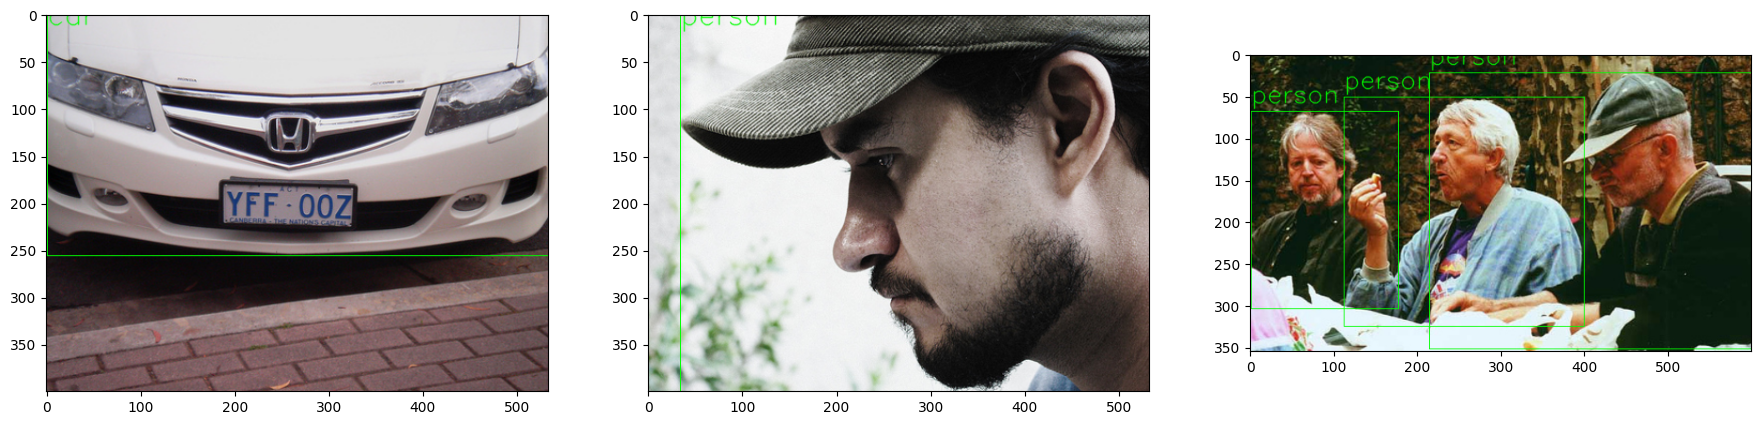

In [62]:
# visualize a batch of train data loader
images, target = next(iter(train_loader))

fig = plt.figure(figsize=(22, 7))
rows, cols = 1, 3
for i in range(0, rows * cols):
    ax = fig.add_subplot(rows, cols, i+1)
    img = np.transpose(images[i], (1, 2, 0))
    img = img.detach().cpu().numpy()
    #img = ((img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]) * 255).astype(np.uint8)
    img = (img * 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    boxes = target[i]['boxes']
    labels = target[i]['labels']

     # Loop through each box and label
    for j in range(len(boxes)):
        # Get coordinates for the rectangle
        x1, y1, x2, y2 = map(int, boxes[j])
        # Draw the rectangle
        cv2.rectangle(img, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=1)

        # Get the label name from VOC_CLASSES using the label ID
        class_id = int(labels[j])
        label_name = VOC_CLASSES_inverted.get(class_id, "Unknown")
        # Set the position for the label text (above the rectangle)
        text_position = (x1, y1 - 10 if y1 > 20 else y1 + 10)

        # Add the label text to the image
        cv2.putText(
            img,
            label_name,
            text_position,
            cv2.FONT_HERSHEY_SIMPLEX,
            1.0,  # Font scale
            (0, 255, 0),  # Text color (same as rectangle color)
            thickness=1,  # Thickness of text
            lineType=cv2.LINE_AA
        )

    plt.imshow(img)
    plt.axis(True);


In [63]:
# check
def check_model_output(model, val_loader, device):
    model.eval()

    # Get one batch of data
    images, targets = next(iter(val_loader))
    images = list(image.to(device) for image in images)

    # Get model predictions
    with torch.no_grad():
        outputs = model(images)

    # Print detailed information about the output
    print("Type of model output:", type(outputs))  # Should be list
    print("\nLength of outputs (batch size):", len(outputs))

    # Look at first prediction in batch
    first_pred = outputs[0]
    print("\nFirst prediction contains:")
    print("Keys:", first_pred.keys())  # Should show 'boxes', 'labels', 'scores'

    print("\nDetailed structure:")
    print("Boxes shape:", first_pred['boxes'].shape)  # [N, 4] where N is number of detections
    print("Labels shape:", first_pred['labels'].shape)  # [N]
    print("Scores shape:", first_pred['scores'].shape)  # [N]

    # Print sample values
    print("\nSample values for first detection:")
    if len(first_pred['boxes']) > 0:
        print("Box coordinates (x1,y1,x2,y2):", first_pred['boxes'][0].tolist())
        print("Label:", first_pred['labels'][0].item())
        print("Confidence score:", first_pred['scores'][0].item())

    return outputs

# usage:
pred_output = check_model_output(model, val_loader, device)

Type of model output: <class 'list'>

Length of outputs (batch size): 8

First prediction contains:
Keys: dict_keys(['boxes', 'labels', 'scores'])

Detailed structure:
Boxes shape: torch.Size([100, 4])
Labels shape: torch.Size([100])
Scores shape: torch.Size([100])

Sample values for first detection:
Box coordinates (x1,y1,x2,y2): [427.8806457519531, 222.89064025878906, 509.6532897949219, 251.10569763183594]
Label: 4
Confidence score: 0.39997267723083496


In [64]:
# Check
def check_target_format(val_loader):
    # Get one batch
    images, targets = next(iter(val_loader))

    print("Target format:")
    print("Type of targets:", type(targets))
    print("Number of targets:", len(targets))

    # Look at first target
    first_target = targets[0]
    print("\nFirst target contains:")
    print("Keys:", first_target.keys())

    # Print shapes
    for key, value in first_target.items():
        print(f"{key} shape:", value.shape)
        print(f"Sample {key}:", value[0] if len(value) > 0 else "empty")

# Usage:
check_target_format(val_loader)

Target format:
Type of targets: <class 'list'>
Number of targets: 8

First target contains:
Keys: dict_keys(['boxes', 'labels', 'image_id'])
boxes shape: torch.Size([2, 4])
Sample boxes: tensor([426.4000, 214.4000, 515.9440, 261.3333])
labels shape: torch.Size([2])
Sample labels: tensor(3)
image_id shape: torch.Size([1])
Sample image_id: tensor(0)


## Metrics

In [65]:
# """Calculate mean Average Precision"""
def calculate_map(predictions, targets, iou_threshold=0.5):
    """Calculate mean Average Precision"""
    # Initialize variables for mAP calculation
    aps = []
    unique_labels = set()

    # Get all unique class labels
    for target in targets:
        unique_labels.update(target['labels'].cpu().numpy())

    # Calculate AP for each class
    for class_id in unique_labels:
        true_positives = []
        scores = []
        num_gt = 0

        # Go through all images
        for pred, target in zip(predictions, targets):
            pred_boxes = pred['boxes']
            pred_scores = pred['scores']
            pred_labels = pred['labels']

            target_boxes = target['boxes']
            target_labels = target['labels']

            # Count ground truths for this class
            num_gt += (target_labels == class_id).sum().item()

            # Get predictions for this class
            class_label = pred_labels == class_id
            class_boxes = pred_boxes[class_label]
            class_scores = pred_scores[class_label]

            # Get ground truth boxes for this class
            gt_mask = target_labels == class_id
            gt_boxes = target_boxes[gt_mask]

            if len(class_boxes) > 0 and len(gt_boxes) > 0:
                # Calculate IoU between predictions and ground truth
                ious = box_iou(class_boxes, gt_boxes)

                # For each prediction, check if it matches ground truth
                for i in range(len(class_boxes)):
                    scores.append(class_scores[i].item())
                    if ious[i].max() >= iou_threshold:
                        true_positives.append(1)
                    else:
                        true_positives.append(0)

        if len(scores) > 0:
            # Sort by score
            scores = torch.tensor(scores)
            true_positives = torch.tensor(true_positives)
            sorted_indices = torch.argsort(scores, descending=True)
            true_positives = true_positives[sorted_indices]

            # Calculate precision and recall points
            cumsum = torch.cumsum(true_positives, dim=0)
            precision = cumsum / torch.arange(1, len(cumsum) + 1)
            recall = cumsum / num_gt if num_gt > 0 else cumsum * 0

            # Calculate AP using 11-point interpolation
            ap = 0
            for t in torch.linspace(0, 1, 11):
                if torch.sum(recall >= t) == 0:
                    p = 0
                else:
                    p = torch.max(precision[recall >= t])
                ap += p / 11
            aps.append(ap.item())

    return sum(aps) / len(aps) if aps else 0


In [66]:
# """Calculate overall precision and recall"""
def calculate_precision_recall(predictions, targets, iou_threshold=0.5, score_threshold=0.5):
    """Calculate overall precision and recall"""
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    for pred, target in zip(predictions, targets):
        pred_boxes = pred['boxes']
        pred_scores = pred['scores']
        target_boxes = target['boxes']

        # Filter predictions by score threshold
        mask = pred_scores >= score_threshold
        pred_boxes = pred_boxes[mask]

        if len(pred_boxes) > 0 and len(target_boxes) > 0:
            # Calculate IoU between predictions and ground truth
            ious = box_iou(pred_boxes, target_boxes)

            # Count matches
            pred_matches = ious.max(dim=1)[0] >= iou_threshold
            target_matches = ious.max(dim=0)[0] >= iou_threshold

            true_positives += pred_matches.sum().item()
            false_positives += (~pred_matches).sum().item()
            false_negatives += (~target_matches).sum().item()
        else:
            false_positives += len(pred_boxes)
            false_negatives += len(target_boxes)

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    return precision, recall


In [67]:
def calculate_f1_score(precision, recall):
    return 2 * (precision * recall) / (precision + recall + 1e-8)

In [68]:
# """Calculate IoU between two sets of boxes"""
def box_iou(boxes1, boxes2):
    """Calculate IoU between two sets of boxes"""
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])

    lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])

    wh = (rb - lt).clamp(min=0)
    inter = wh[:, :, 0] * wh[:, :, 1]

    union = area1[:, None] + area2 - inter

    iou = inter / (union + 1e-6)

    return iou


In [69]:
def calculate_batch_iou(predictions, targets):
    """Calculate IoU for a batch of predictions"""
    total_iou = 0
    count = 0

    for pred, target in zip(predictions, targets):
        pred_boxes = pred['boxes']
        target_boxes = target['boxes']

        if len(pred_boxes) > 0 and len(target_boxes) > 0:
            # Calculate IoU between predicted and target boxes
            ious = box_iou(pred_boxes, target_boxes)
            # Take the maximum IoU for each predicted box
            total_iou += ious.max(dim=1)[0].mean().item()
            count += 1

    return total_iou / count if count > 0 else 0

## Train Process

In [70]:
def track_performance(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        start_memory = memory_profiler.memory_usage()[0]

        result = func(*args, **kwargs)

        end_time = time.time()
        end_memory = memory_profiler.memory_usage()[0]

        print(f"Function: {func.__name__}")
        print(f"Execution Time: {((end_time - start_time)/60):.2f} minutes")
        print(f"Memory Usage: {end_memory - start_memory:.2f} MB")

        return result
    return wrapper

In [71]:
@track_performance
def train_one_epoch(model, optimizer, train_loader, device):

    model.train()
    total_loss = 0

    with tqdm(train_loader, unit="batch", desc="Training", leave=True, bar_format='{desc:<5.5}{percentage:3.0f}%|{bar:50}{r_bar}') as tepoch:
        for images, targets in tepoch:
            # Move data to device
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Clear gradients before forward pass
            optimizer.zero_grad()
            # Forward pass
            loss_dict = model(images, targets)
            # Calculate total loss
            losses = sum(loss for loss in loss_dict.values())
            # Backward pass
            losses.backward()
            # Add gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            # Update weights
            optimizer.step()
            # Update total loss
            total_loss += losses.item()

            tepoch.set_postfix(loss=losses.item())

    return total_loss / len(train_loader)


In [72]:
@track_performance
def evaluate(model, val_loader, device):

    model.eval()

    metrics = {
        'mAP': 0,
        'precision': 0,
        'recall': 0,
        'f1_score': 0,
        'bbox_iou': 0
    }

    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, targets in tqdm(val_loader, leave=False, bar_format='{desc:<5.5}{percentage:3.0f}%|{bar:50}{r_bar}'):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Get predictions
            outputs = model(images)

            # Store predictions and targets for metric calculation
            all_predictions.extend(outputs)
            all_targets.extend(targets)

            # Calculate batch IoU
            batch_iou = calculate_batch_iou(outputs, targets)
            metrics['bbox_iou'] += batch_iou

    # Calculate average IoU
    metrics['bbox_iou'] /= len(val_loader)

    # Calculate mAP
    metrics['mAP'] = calculate_map(all_predictions, all_targets)

    # Calculate precision and recall
    precision, recall = calculate_precision_recall(all_predictions, all_targets)
    metrics['precision'] = precision
    metrics['recall'] = recall

    # Calculate f1_score
    f1_score = calculate_f1_score(precision, recall)
    metrics['f1_score'] = f1_score

    return metrics


In [73]:
# train model
@track_performance
def train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs, device, save_path='checkpoints'):

    best_map = 0.0  # Track best mAP
    os.makedirs(save_path, exist_ok=True)

    # Initialize dictionary to store metrics
    history = {
        'train_loss': [],
        'val_map': [],
        'val_precision': [],
        'val_recall': [],
        'val_iou': [],
        'val_f1_score': []
    }

    # Early stopping
    patience = Config.patience
    patience_counter = 0

    for epoch in range(num_epochs):

        # Training phase
        train_loss = train_one_epoch(model, optimizer, train_loader, device)

        # Validation phase
        metrics = evaluate(model, val_loader, device)
        current_map = metrics['mAP']

        # scheduling step
        # Learning rate scheduling
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(current_map)
        else:
            scheduler.step()

        # Store metrics in history
        history['train_loss'].append(train_loss)
        history['val_map'].append(metrics['mAP'])
        history['val_precision'].append(metrics['precision'])
        history['val_recall'].append(metrics['recall'])
        history['val_iou'].append(metrics['bbox_iou'])
        history['val_f1_score'].append(metrics['f1_score'])

        # Print epoch results
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Training Loss: {train_loss:.4f}")
        print(f"Validation mAP: {metrics['mAP']:.4f}")
        print(f"Validation Precision: {metrics['precision']:.4f}")
        print(f"Validation Recall: {metrics['recall']:.4f}")
        print(f"Validation IoU: {metrics['bbox_iou']:.4f}")

        # Save best model
        if current_map > best_map:
            patience_counter = 0
            best_map = current_map
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_map': best_map,
                'history':history
            }
            torch.save(checkpoint, f"{save_path}/best_model_fasterRCNN.pth")
            print(f"New best model saved with mAP: {best_map:.4f}")
        else:
            patience_counter += 1

        # Save checkpoint every N epochs (e.g., every 5 epochs)
        if (epoch + 1) % 5 == 0:
            checkpoint = {
               'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_map': best_map,
                'history':history
            }
            torch.save(checkpoint, f"{save_path}/model_epoch_{epoch+1}_fasterRCNN.pth")

        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    return model, history


In [74]:
def plot_training_history(history):
    """Plot training and validation metrics using dictionary input"""
    plt.figure(figsize=(18, 8))

    # Plot training loss
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot mAP
    plt.subplot(2, 2, 2)
    plt.plot(history['val_map'], label='Validation mAP')
    plt.title('Validation mAP over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('mAP')
    plt.legend()
    plt.grid(True)

    # Plot Precision/Recall
    plt.subplot(2, 2, 3)
    plt.plot(history['val_precision'], label='Precision')
    plt.plot(history['val_recall'], label='Recall')
    plt.title('Precision and Recall over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)

    # Plot IoU
    plt.subplot(2, 2, 4)
    plt.plot(history['val_iou'], label='Validation IoU')
    plt.title('Validation IoU over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('training_history_Faster_RCNN.png')
    plt.show()
    plt.close()

### Train the model

In [75]:
# Prepare optimizer and scheduler
params = [param for name, param in model.named_parameters() if param.requires_grad]
optimizer = torch.optim.SGD(params, lr=Config.learning_rate, momentum=Config.momentum, weight_decay=Config.weight_decay)
#optimizer = torch.optim.Adam(params, lr=Config.learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=Config.patience)
#scheduler = get_lr_scheduler(optimizer, Config.num_epochs)
# cosine annealing scheduler
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=Config.num_epochs)


In [76]:
# Train the model
model, history = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    Config.num_epochs,
    device
)

Train100%|██████████████████████████████████████████████████| 561/561 [09:08<00:00,  1.02batch/s, loss=0.164]


Function: train_one_epoch
Execution Time: 9.15 minutes
Memory Usage: 72.93 MB


Function: evaluate
Execution Time: 1.04 minutes
Memory Usage: 1.02 MB

Epoch 1/30
Training Loss: 0.2615
Validation mAP: 0.9159
Validation Precision: 0.6981
Validation Recall: 0.8529
Validation IoU: 0.4025
New best model saved with mAP: 0.9159


Train100%|██████████████████████████████████████████████████| 561/561 [09:10<00:00,  1.02batch/s, loss=0.135]


Function: train_one_epoch
Execution Time: 9.18 minutes
Memory Usage: 2.95 MB


Function: evaluate
Execution Time: 1.03 minutes
Memory Usage: 0.05 MB

Epoch 2/30
Training Loss: 0.1882
Validation mAP: 0.8972
Validation Precision: 0.7320
Validation Recall: 0.8489
Validation IoU: 0.4403


Train100%|██████████████████████████████████████████████████| 561/561 [09:09<00:00,  1.02batch/s, loss=0.115]


Function: train_one_epoch
Execution Time: 9.16 minutes
Memory Usage: 2.54 MB


Function: evaluate
Execution Time: 1.03 minutes
Memory Usage: 0.00 MB

Epoch 3/30
Training Loss: 0.1698
Validation mAP: 0.9061
Validation Precision: 0.7301
Validation Recall: 0.8535
Validation IoU: 0.4501


Train100%|██████████████████████████████████████████████████| 561/561 [09:09<00:00,  1.02batch/s, loss=0.0662]


Function: train_one_epoch
Execution Time: 9.17 minutes
Memory Usage: 0.37 MB


Function: evaluate
Execution Time: 1.04 minutes
Memory Usage: 0.20 MB

Epoch 4/30
Training Loss: 0.1583
Validation mAP: 0.8987
Validation Precision: 0.6953
Validation Recall: 0.8683
Validation IoU: 0.4393


Train100%|██████████████████████████████████████████████████| 561/561 [09:07<00:00,  1.02batch/s, loss=0.147]


Function: train_one_epoch
Execution Time: 9.13 minutes
Memory Usage: 3.35 MB


Function: evaluate
Execution Time: 1.02 minutes
Memory Usage: 0.00 MB

Epoch 5/30
Training Loss: 0.1496
Validation mAP: 0.8950
Validation Precision: 0.7216
Validation Recall: 0.8541
Validation IoU: 0.4646


Train100%|██████████████████████████████████████████████████| 561/561 [09:08<00:00,  1.02batch/s, loss=0.0733]


Function: train_one_epoch
Execution Time: 9.15 minutes
Memory Usage: 1.80 MB


Function: evaluate
Execution Time: 1.03 minutes
Memory Usage: 0.26 MB

Epoch 6/30
Training Loss: 0.1411
Validation mAP: 0.8927
Validation Precision: 0.7027
Validation Recall: 0.8634
Validation IoU: 0.4796


Train100%|██████████████████████████████████████████████████| 561/561 [09:09<00:00,  1.02batch/s, loss=0.0639]


Function: train_one_epoch
Execution Time: 9.15 minutes
Memory Usage: 5.16 MB


Function: evaluate
Execution Time: 1.04 minutes
Memory Usage: 0.00 MB

Epoch 7/30
Training Loss: 0.1331
Validation mAP: 0.8925
Validation Precision: 0.7069
Validation Recall: 0.8616
Validation IoU: 0.4948


Train100%|██████████████████████████████████████████████████| 561/561 [09:08<00:00,  1.02batch/s, loss=0.0589]


Function: train_one_epoch
Execution Time: 9.14 minutes
Memory Usage: 2.87 MB


Function: evaluate
Execution Time: 1.03 minutes
Memory Usage: 0.25 MB

Epoch 8/30
Training Loss: 0.1265
Validation mAP: 0.8965
Validation Precision: 0.7197
Validation Recall: 0.8557
Validation IoU: 0.5114


Train100%|██████████████████████████████████████████████████| 561/561 [09:05<00:00,  1.03batch/s, loss=0.0743]


Function: train_one_epoch
Execution Time: 9.10 minutes
Memory Usage: 1.29 MB


Function: evaluate
Execution Time: 1.02 minutes
Memory Usage: 0.26 MB

Epoch 9/30
Training Loss: 0.1196
Validation mAP: 0.8823
Validation Precision: 0.7229
Validation Recall: 0.8504
Validation IoU: 0.5273


Train100%|██████████████████████████████████████████████████| 561/561 [09:09<00:00,  1.02batch/s, loss=0.0494]


Function: train_one_epoch
Execution Time: 9.17 minutes
Memory Usage: 0.00 MB


Function: evaluate
Execution Time: 1.02 minutes
Memory Usage: 0.00 MB

Epoch 10/30
Training Loss: 0.1143
Validation mAP: 0.8861
Validation Precision: 0.7122
Validation Recall: 0.8538
Validation IoU: 0.5420


Train100%|██████████████████████████████████████████████████| 561/561 [09:08<00:00,  1.02batch/s, loss=0.113]


Function: train_one_epoch
Execution Time: 9.14 minutes
Memory Usage: 0.00 MB


Function: evaluate
Execution Time: 1.02 minutes
Memory Usage: 0.00 MB

Epoch 11/30
Training Loss: 0.1083
Validation mAP: 0.8828
Validation Precision: 0.7403
Validation Recall: 0.8423
Validation IoU: 0.5639
Early stopping triggered after 11 epochs
Function: train_model
Execution Time: 112.34 minutes
Memory Usage: 39.96 MB


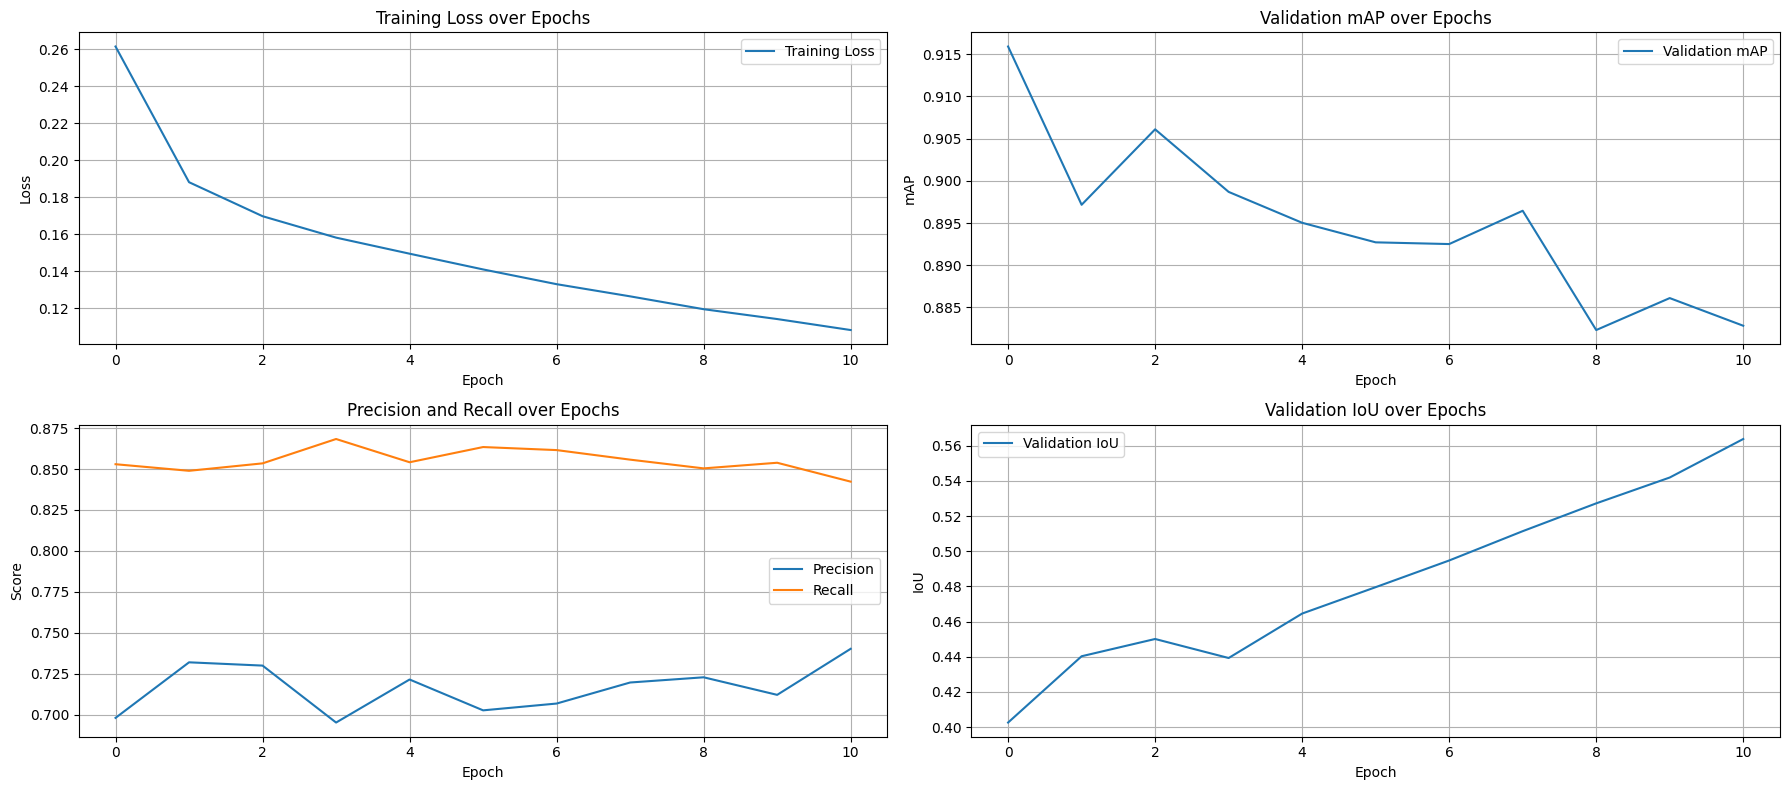

Best mAP: 0.9159 at epoch 1
Corresponding Precision: 0.6981
Corresponding Recall: 0.8529


In [77]:
# Plot training history
plot_training_history(history)

# Get best mAP value
best_map = max(history['val_map'])
best_epoch = history['val_map'].index(best_map)

# Print best results
print(f"Best mAP: {best_map:.4f} at epoch {best_epoch + 1}")
print(f"Corresponding Precision: {history['val_precision'][best_epoch]:.4f}")
print(f"Corresponding Recall: {history['val_recall'][best_epoch]:.4f}")

In [78]:
# Function to load the best model
def load_best_model(model, optimizer, load_path):
    if os.path.exists(load_path):
        checkpoint = torch.load(load_path, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        best_map = checkpoint['best_map']
        epoch = checkpoint['epoch']
        history = checkpoint['history']
        print(f"Loaded best model with mAP: {best_map:.4f} from epoch {checkpoint['epoch']+1}")
        return model, optimizer, best_map, epoch, history
    else:
        print("No saved model found.")
        return model, optimizer, 0.0, -1

In [79]:
# predict
def predict_image(model, image, device, confidence_threshold=0.7):

    model.eval()

    transform.normalize = False
    image, _ = transform(image, None)

    # Prepare image for model
    image = image.to(device)

    # Get predictions
    with torch.no_grad():
        predictions = model([image])

    # Get boxes, labels and scores
    boxes = predictions[0]['boxes'].cpu()
    labels = predictions[0]['labels'].cpu()
    scores = predictions[0]['scores'].cpu()

    # Filter by confidence
    mask = scores >= confidence_threshold
    boxes = boxes[mask]
    labels = labels[mask]
    scores = scores[mask]

    return image, boxes, labels, scores

In [80]:
def visualize_predictions(image, boxes, labels, scores, classes, save_path="predictions_img"):

    # Create figure and axes
    fig, ax = plt.subplots(1, figsize=(18, 12))

    img = image.detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    #img = ((img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]) * 255).astype(np.uint8)

    ax.imshow(img)

    classes_inverted = {v: k for k, v in classes.items()}

    # Draw each box
    for box, label, score in zip(boxes, labels, scores):
        # Convert box coordinates to integers
        box = box.numpy().astype(np.int32)

        # Create rectangle patch
        rect = patches.Rectangle(
            (box[0], box[1]),
            box[2] - box[0],
            box[3] - box[1],
            linewidth=2,
            edgecolor='r',
            facecolor='none'
        )
        ax.add_patch(rect)
        # Add label and score
        class_name = classes_inverted.get(label.item(), "Unknown") # classes start in 1, do not substract???
        ax.text(
            box[0],
            box[1] - 5,
            f'{class_name}: {score:.2f}',
            bbox=dict(facecolor='red', alpha=0.5),
            color='white'
        )

    # Remove axes
    plt.axis('off')

    # Save if path provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.show()
        plt.close()
    else:
        plt.show()


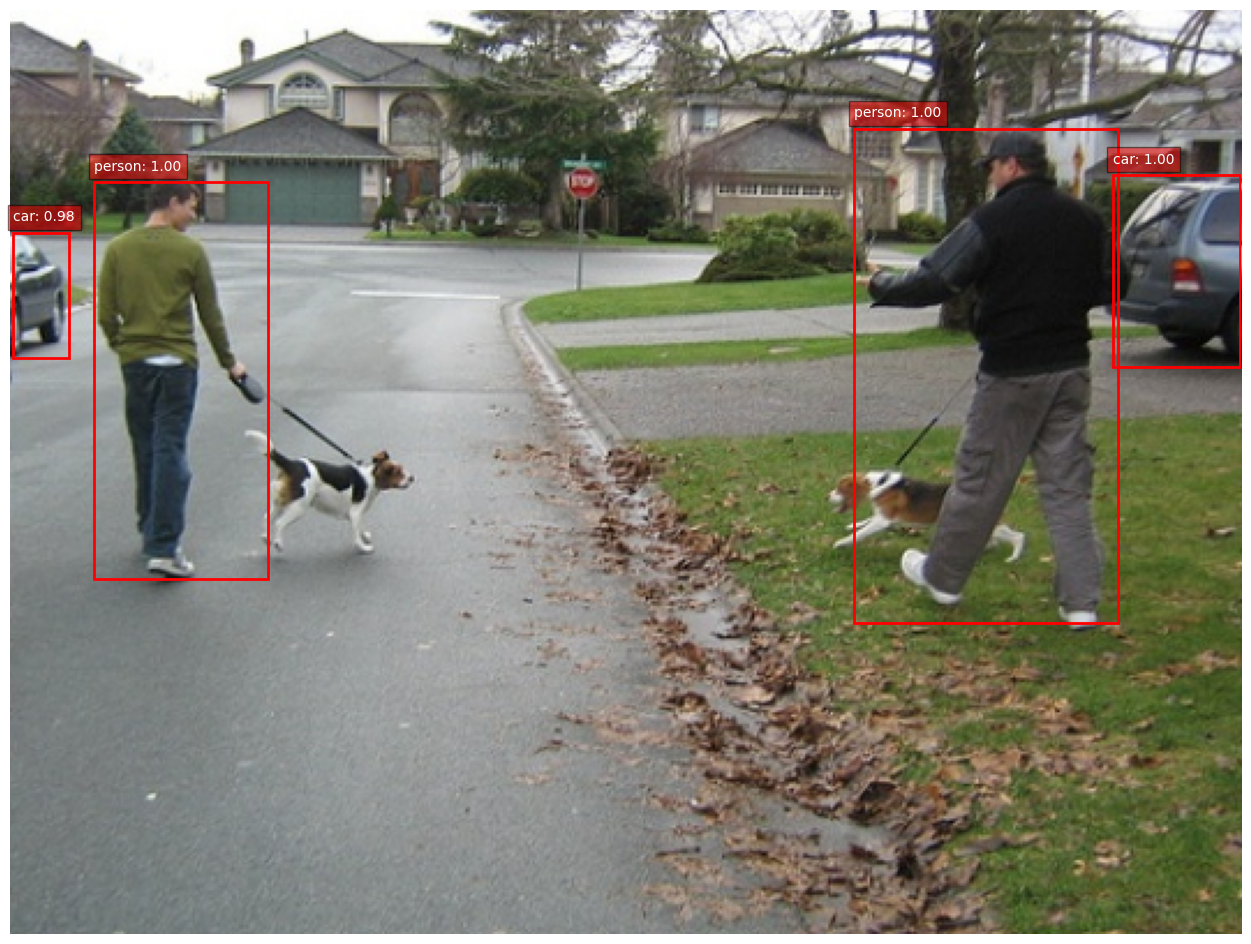

In [81]:
# Single image inference
image_path = '/content/VOC_data/VOCdevkit/VOC2012/JPEGImages/2007_005988.jpg'
#image_path = 'VOC2012/JPEGImages/2007_005988.jpg'
image_raw = Image.open(image_path).convert('RGB')

image, boxes, labels, scores = predict_image(model, image_raw, device)   # image, ???
visualize_predictions(image, boxes, labels, scores, VOC_CLASSES_ReIndex)

# Batch processing
#batch_inference(model, 'test_images', 'results', VOC_CLASSES, device)

# Save results to CSV
#save_results(boxes, labels, scores, class_names, 'results.csv')

In [84]:
def process_video(model, video_path, output_path, class_names, device,
                 confidence_threshold=0.6, fps=30):
    """
    Process video file and save annotated video
    """
    # Open video file
    cap = cv2.VideoCapture(video_path)
    #cap = cv2.VideoCapture(0)  # Use 0 for default webcam, or provide IP camera URL

    # Check if the camera opened successfully
    if not cap.isOpened():
        print("Error: Could not open video stream.")
        return

    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Create video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
    #out = cv2.VideoWriter(output_path, fourcc, fps, (600, 400)) #resize video output

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("Error: Could not read frame.")
            break

        # Convert BGR to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Convert to PIL Image
        image = Image.fromarray(frame_rgb)

        # Get predictions
        image, boxes, labels, scores = predict_image(model, image_raw, device)

        # Draw predictions on frame
        for box, label, score in zip(boxes, labels, scores):
            box = box.numpy().astype(np.int32)
            class_name = VOC_CLASSES_inverted.get(label.item(), "Unknown")

            # Draw box
            cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)

            # Add label
            label_text = f'{class_name}: {score:.2f}'
            cv2.putText(frame, label_text, (box[0], box[1] - 5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Display the processed frame
        #cv2.imshow('Video', frame)

        # Write frame
        out.write(frame)

        # Exit on 'q' key press
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release everything
    cap.release()
    out.release()
    cv2.destroyAllWindows()


In [ ]:
# Video processing
process_video(model, '/content/input.mp4', 'output.mp4', VOC_CLASSES, device)

In [ ]:
# Video processing
#process_video(model, 0, 'output_web.mp4', VOC_CLASSES, device)